In [1]:
# Import standard libraries
from __future__ import absolute_import, division, print_function

import codecs # for word encoding
import glob # for regular expressions
import multiprocessing # concurrency
import os # os stuff, like reading a file
import pprint # pretty printing
import re # regular expressions


In [3]:
# Import external libraries
import nltk # natural language procession
import gensim.models.word2vec as w2v # word 2 vec
import sklearn.manifold #dimensionality reduction
import numpy as np # math
import matplotlib.pyplot as plt # plotting
import pandas as pd
import seaborn as sns

In [4]:
# Step 1 - process the data
# clean data

nltk.download('punkt') # pretrained tokenizer
nltk.download('stopwords') # words like and, the, a, an, of

[nltk_data] Downloading package punkt to /home/paperspace/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/paperspace/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [5]:
#get the book filenames
book_filenames = sorted(glob.glob("data_war/*.txt"))
book_filenames

['data_war/A Dangerous Path - Erin Hunter.txt',
 "data_war/Bluestar's Prophecy - Erin Hunter.txt",
 'data_war/Dark River - Erin Hunter.txt',
 'data_war/Dawn - Erin Hunter.txt',
 'data_war/Eclipse - Erin Hunter.txt',
 'data_war/Fading Echoes - Erin Hunter.txt',
 'data_war/Fire and Ice - Erin Hunter.txt',
 'data_war/Fire in the Sky - Erin Hunter.txt',
 'data_war/Forest of Secrets - Erin Hunter.txt',
 'data_war/Into the Wild - Erin Hunter.txt',
 'data_war/Long Shadows - Erin Hunter.txt',
 'data_war/Midnight - Erin Hunter.txt',
 'data_war/Moonrise - Erin Hunter.txt',
 'data_war/Night Whispers - Erin Hunter.txt',
 'data_war/Outcast - Erin Hunter.txt',
 'data_war/Rising Storm - Erin Hunter.txt',
 'data_war/Seekers #2_ Great Bear Lake - Erin Hunter.txt',
 'data_war/Seekers #3_ Smoke Mountain - Erin Hunter.txt',
 'data_war/Seekers - Erin Hunter.txt',
 'data_war/Starlight - Erin Hunter.txt',
 'data_war/Sunrise - Erin Hunter.txt',
 'data_war/Sunset - Erin Hunter.txt',
 'data_war/The Darkest Hour

In [6]:
corpus_raw = u""

for book_filename in book_filenames:
    print("Reading '{0}'...".format(book_filename))
    with codecs.open(book_filename, "r", "utf-8") as book_file:
        corpus_raw += book_file.read()
    print("Corpus in now {0} characters long".format(len(corpus_raw)))
    print()

Reading 'data_war/A Dangerous Path - Erin Hunter.txt'...
Corpus in now 462754 characters long

Reading 'data_war/Bluestar's Prophecy - Erin Hunter.txt'...
Corpus in now 1137899 characters long

Reading 'data_war/Dark River - Erin Hunter.txt'...
Corpus in now 1583229 characters long

Reading 'data_war/Dawn - Erin Hunter.txt'...
Corpus in now 2052737 characters long

Reading 'data_war/Eclipse - Erin Hunter.txt'...
Corpus in now 2492331 characters long

Reading 'data_war/Fading Echoes - Erin Hunter.txt'...
Corpus in now 2958458 characters long

Reading 'data_war/Fire and Ice - Erin Hunter.txt'...
Corpus in now 3424214 characters long

Reading 'data_war/Fire in the Sky - Erin Hunter.txt'...
Corpus in now 3780524 characters long

Reading 'data_war/Forest of Secrets - Erin Hunter.txt'...
Corpus in now 4242279 characters long

Reading 'data_war/Into the Wild - Erin Hunter.txt'...
Corpus in now 4641868 characters long

Reading 'data_war/Long Shadows - Erin Hunter.txt'...
Corpus in now 5107046 

In [7]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [8]:
raw_sentences = tokenizer.tokenize(corpus_raw)

In [9]:
def sentence_to_wordlist(raw):
    clean = re.sub("[^a-zA-Z]"," ", raw)
    words = clean.split()
    return words
#returns list of words, removes puncutation and hyphens

In [10]:
# sentence where each word is tokenized
sentences = []
for raw_sentence in raw_sentences:
    if len(raw_sentence) > 0:
        sentences.append(sentence_to_wordlist(raw_sentence))

In [11]:
print(raw_sentences[5])
print(sentence_to_wordlist(raw_sentences[5]))

CHAPTER 18

As Fireheart wearily pushed his way through the entrance to…

CHAPTER 19

Next morning, Fireheart watched the dawn patrol leave before going…

CHAPTER 20

“Will she live?” Fireheart asked anxiously.
[u'CHAPTER', u'As', u'Fireheart', u'wearily', u'pushed', u'his', u'way', u'through', u'the', u'entrance', u'to', u'CHAPTER', u'Next', u'morning', u'Fireheart', u'watched', u'the', u'dawn', u'patrol', u'leave', u'before', u'going', u'CHAPTER', u'Will', u'she', u'live', u'Fireheart', u'asked', u'anxiously']


In [12]:
token_count = sum([len(sentence) for sentence in sentences])
print("The book corpus contains {0:,} tokens".format(token_count))

The book corpus contains 2,755,537 tokens


# Train Word 2 Vec

In [13]:
# Step 2 - build the models
# 3 tasks vectors help with
# Distance, Similarity, Ranking


# define hyperparameters
num_features = 300 # more features = more expensive to train, but more accurate
min_word_count = 3
num_workers = multiprocessing.cpu_count() # more workers = faster training
context_size = 7

# Downsample setting for frequent words.
# between 0 and 1e-5 
# how often to use
downsampling = 1e-3

# Seed for random number generator
seed = 42

In [14]:
warriors2vec = w2v.Word2Vec(
    sg = 1,
    seed = seed,
    workers = num_workers,
    size = num_features,
    min_count = min_word_count,
    window = context_size,
    sample = downsampling,
)

In [15]:
warriors2vec.build_vocab(sentences)

In [16]:
print("Word2Vec vocabulary length:", len(warriors2vec.wv.vocab))

Word2Vec vocabulary length: 12490


In [19]:
token_count = sum([len(sentence) for sentence in sentences])
token_count

2755537

In [20]:
warriors2vec.train(sentences, total_examples = token_count, 
                   epochs=warriors2vec.iter)

10904840

## Save the model to file

In [21]:
# save the model
if not os.path.exists("trained"):
    os.makedirs("trained")

In [22]:
warriors2vec.save(os.path.join("trained", "warriors2vec.w2v"))

## Load the trained model - Start here

In [23]:
# load the model - in case this is re-run
warriors2vec = w2v.Word2Vec.load(os.path.join("trained", "warriors2vec.w2v"))

In [24]:
tsne = sklearn.manifold.TSNE(n_components=2, random_state=42)

In [25]:
all_word_vectors_matrix = warriors2vec.wv.syn0

In [26]:
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)

In [39]:
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[warriors2vec.wv.vocab[word].index])
            for word in warriors2vec.wv.vocab
        ]
    ],
    columns=["word", "x", "y"]
)

In [52]:
points.head(10)

,word,x,y
0,fawn,0.462341,1.869711
1,raining,-0.027310,-2.223348
2,yellow,-3.735496,1.579623
3,four,-2.820867,-1.230360
4,Does,0.135486,-4.262761
5,clotted,1.609354,2.538388
6,hanging,-1.080240,2.693956
7,Until,-2.045977,-2.419687
8,aggression,-1.467968,-1.940973
9,marching,-0.886006,-0.234509


In [54]:
sns.set_context("poster")
%matplotlib inline

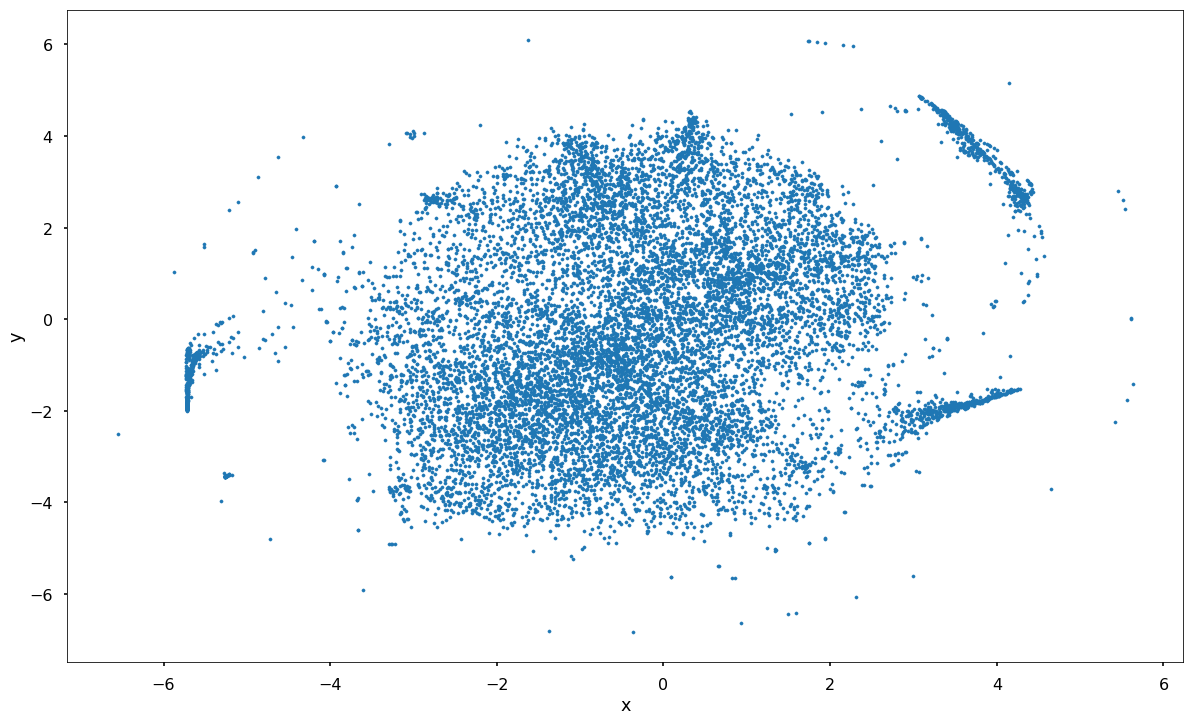

In [55]:
points.plot.scatter("x", "y", s=10, figsize=(20, 12))

In [50]:
def plot_region(x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

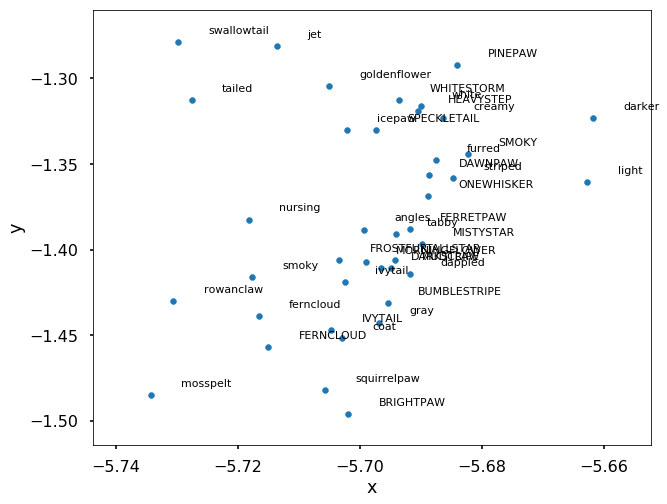

In [58]:
plot_region(x_bounds=(-5.75,-5.5), y_bounds=(-1.5, -1.25))

## Explore semantic similarities between book characters

In [27]:
warriors2vec.most_similar("Firestar")

[(u'Duststar', 0.48959881067276),
 (u'Sunfall', 0.47251540422439575),
 (u'Blackstar', 0.47212982177734375),
 (u'Whitestar', 0.47176751494407654),
 (u'Hawkstar', 0.47056448459625244),
 (u'Bramblestar', 0.4629107117652893),
 (u'Fernshade', 0.44296979904174805),
 (u'Sunpelt', 0.4424307644367218),
 (u'Splashheart', 0.44210243225097656),
 (u'Dovestar', 0.4379351735115051)]

In [28]:
warriors2vec.most_similar("Graystripe")

[(u'Millie', 0.520440936088562),
 (u'Pebblefoot', 0.45836004614830017),
 (u'Stoatpaw', 0.44065061211586),
 (u'Scorchpaw', 0.4383452236652374),
 (u'Brambleclaw', 0.4381425380706787),
 (u'warningly', 0.43582749366760254),
 (u'Olivenose', 0.43296384811401367),
 (u'Cloudtail', 0.43211954832077026),
 (u'mending', 0.4303705096244812),
 (u'sourly', 0.4257736802101135)]

In [29]:
warriors2vec.most_similar("Twolegs")

[(u'monsters', 0.47138676047325134),
 (u'parked', 0.466766357421875),
 (u'Nofurs', 0.46616291999816895),
 (u'Stealing', 0.46247172355651855),
 (u'pampered', 0.462049275636673),
 (u'destroying', 0.45815593004226685),
 (u'trucks', 0.45721322298049927),
 (u'hawks', 0.45548585057258606),
 (u'poisonbeasts', 0.45129334926605225),
 (u'cabin', 0.44937053322792053)]

In [30]:
warriors2vec.most_similar("mousebrain")

[(u'Anytime', 0.7162085771560669),
 (u'Positive', 0.7120891213417053),
 (u'talkin', 0.7052593231201172),
 (u'asserted', 0.6959200501441956),
 (u'meekly', 0.6952630877494812),
 (u'tartly', 0.694341778755188),
 (u'peaceably', 0.692042887210846),
 (u'em', 0.6867173910140991),
 (u'hey', 0.6857600808143616),
 (u'dryly', 0.6819195747375488)]

In [31]:
def nearest_similarity_cosmul(start1, end1, end2):
    similarities = warriors2vec.most_similar_cosmul(
        positive = [end2, start1],
        negative = [end1]
    )
    start2 = similarities[0][0]
    print("{start1} is related to {end1}, as {start2} is related to {end2}".format(**locals()))
    return start2

In [32]:
nearest_similarity_cosmul("Rusty", "Firestar", "Graystripe")
#nearest_similarity_cosmul("Thunderclan", "Riverclan", "Firestar")
nearest_similarity_cosmul("Thunderclan", "Bluestar", "Graystripe")

Rusty is related to Firestar, as Floss is related to Graystripe
Thunderclan is related to Bluestar, as Pebblefoot is related to Graystripe


u'Pebblefoot'

In [33]:
warriors2vec.most_similar("Vinestar")

[(u'disputed', 0.6738656759262085),
 (u'appointment', 0.6724942922592163),
 (u'Calling', 0.6658523082733154),
 (u'messengers', 0.652526319026947),
 (u'Escort', 0.6517702341079712),
 (u'Revenge', 0.6414340138435364),
 (u'grievances', 0.6368741393089294),
 (u'joins', 0.636393129825592),
 (u'Prickleface', 0.6304097175598145),
 (u'Talonpaw', 0.6302000284194946)]

In [34]:
warriors2vec.most_similar("Rusty")

[(u'uncharacteristical', 0.4373761713504791),
 (u'Firepaw', 0.43199896812438965),
 (u'modestly', 0.43092799186706543),
 (u'eh', 0.41293179988861084),
 (u'Henry', 0.40421366691589355),
 (u'harsher', 0.4036065936088562),
 (u'taunts', 0.3978283405303955),
 (u'indecisive', 0.3975006639957428),
 (u'disgruntled', 0.394533634185791),
 (u'Scree', 0.39433905482292175)]

In [35]:
warriors2vec.most_similar("Cinderheart")

[(u'evasively', 0.4680496156215668),
 (u'Weaselpaw', 0.45905351638793945),
 (u'downcast', 0.4582086205482483),
 (u'reassuringly', 0.45279133319854736),
 (u'meaningfully', 0.4513612389564514),
 (u'cheery', 0.4497349262237549),
 (u'diplomatically', 0.445489764213562),
 (u'disconcerted', 0.444021999835968),
 (u'worriedly', 0.4430544972419739),
 (u'mending', 0.43970316648483276)]

In [36]:
warriors2vec.most_similar("Moon")

[(u'Half', 0.8970146775245667),
 (u'Rising', 0.5601568222045898),
 (u'Leap', 0.5126409530639648),
 (u'Fish', 0.4787974953651428),
 (u'Song', 0.4747053384780884),
 (u'ising', 0.4621877074241638),
 (u'Wing', 0.4608812928199768),
 (u'Jagged', 0.4475802183151245),
 (u'Stone', 0.44444310665130615),
 (u'Lightning', 0.4387217164039612)]